### Data preparation

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("course_lead_scoring.txt", delimiter=",")
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
categorical = df.dtypes[df.dtypes == object].index.to_list()

numerical = df.select_dtypes(include=['number']).columns.to_list()
numerical.remove('converted')

In [5]:
df[categorical] = df[categorical].fillna("NA")
df[numerical] = df[numerical].fillna(0.0)

### Split data set

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

In [8]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']


### Question 1

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
#Using auc score to evaluate feature importance for numerical features
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    print(f"{n}: {auc :.3f}")

number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


### Question 2: Training model

In [11]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
model = LogisticRegression(solver='lbfgs', C=1.0, max_iter=10000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [13]:
y_pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)
print(f"ROC AUC on validation set: {round(roc_auc, 3)}")

ROC AUC on validation set: 0.92


### Question 3: Precision and Recall

In [14]:
scores = []

thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))

In [15]:
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)


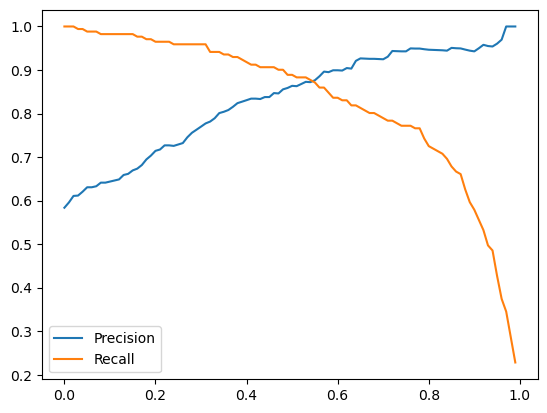

In [16]:
plt.plot(df_scores.threshold, df_scores["precision"], label='Precision')
plt.plot(df_scores.threshold, df_scores["recall"], label='Recall')
plt.legend()

### Question 4: F1 score

In [17]:
df_scores["f1"] = 2 * (df_scores["precision"] * df_scores["recall"]) / (df_scores["precision"] + df_scores["recall"])
df_scores.head()

,threshold,precision,recall,f1
0,0.00,0.583618,1.000000,0.737069
1,0.01,0.595819,1.000000,0.746725
2,0.02,0.610714,1.000000,0.758315
3,0.03,0.611511,0.994152,0.757238
4,0.04,0.620438,0.994152,0.764045


In [18]:
max_f1 = df_scores['f1'].max()
best_threshold = df_scores.loc[df_scores['f1'] == max_f1, 'threshold'].values[0]
print(f"Best threshold: {best_threshold}, F1 Score: {max_f1}")

Best threshold: 0.53, F1 Score: 0.877906976744186


### Question 5: 5-Fold CV

In [32]:
# Model training function
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [33]:
# model prediction function
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [34]:
from sklearn.model_selection import KFold

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.converted.values
    y_val = df_val.converted.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"CV ROC AUC scores: {scores}")
print(f"STD CV ROC AUC: {round(np.std(scores), 3)}")



CV ROC AUC scores: [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
STD CV ROC AUC: 0.036


### Question 6: Hyperparameter tuning


In [ ]:
!pip install tqdm

In [37]:
from tqdm.auto import tqdm

In [38]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
